In [1]:
import pandas as pd
import numpy as np
import theano
import theano.tensor as T
import lasagne
import matplotlib.pyplot as plt
%matplotlib inline
from lasagne.regularization import regularize_network_params, l2, l1
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
# import nltk
# from nltk import word_tokenize          
# from nltk.stem.porter import PorterStemmer
floatX = theano.config.floatX

# Vectorize data

In [2]:
train_df = pd.DataFrame.from_csv('../data/clean/train_reviews.csv')
val_df = pd.DataFrame.from_csv('../data/clean/val_reviews.csv')
train_df.head(10)

,hour_of_gameplay,content_review,helpful_vote,total_vote,funny_vote,number_comment,polarity
ID,,,,,,,
730,48.8,this game is apperently filled with hackers so...,1,1,0,0,0
730,164.6,If i had a gun with 2 bullets in a room with h...,2,2,0,0,1
730,1497.8,My favourite game.Friendly and helpful random ...,1,1,0,0,0
730,1026.0,After the latest update I deinstalled the game...,2,2,0,1,0
730,1595.2,Counter-Strike: Global Offensive is one of the...,2,2,0,0,1
730,282.8,Very nice game,2,2,0,0,1
730,311.1,worst game ever i hate it due to the 7 day bans,1,1,0,0,0
730,314.0,pretty sweaty,3,3,2,0,1
730,231.9,♥♥♥♥ you counterstikre,1,1,1,1,0


In [193]:
# for i in xrange(2000):
#     j = np.random.randint(len(train_df))
#     if len(train_df.iloc[j, 1]) < 100 and train_df.iloc[j, 3] > 500 and train_df.iloc[j, -1] == 0:
#         print j, train_df.iloc[j, 1]
#         print 
# train_df.iloc[16650, :]
# train_df.iloc[32699, :]

hour_of_gameplay                                               2188.4
content_review      This game will truly test the bonds between yo...
helpful_vote                                                      513
total_vote                                                        667
funny_vote                                                          0
number_comment                                                     12
polarity                                                            0
Name: 570, dtype: object

In [45]:
df_sort = train_df.drop_duplicates().sort('funny_vote', ascending=False)
print len(df_sort)
# for i in xrange(200, 300):
#     print df_sort.iloc[i, 1]
#     print 
df_sort.iloc[201, :]

17181


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


hour_of_gameplay                                                 42.7
content_review      In the store page, it says the price is 13,99 ...
helpful_vote                                                      135
total_vote                                                        149
funny_vote                                                        183
number_comment                                                      0
polarity                                                            1
Name: 413150, dtype: object

In [5]:
train_df.dropna(inplace = True)
print train_df.polarity.describe()

count    40114.000000
mean         0.653263
std          0.475937
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: polarity, dtype: float64


In [8]:
val_df.dropna(inplace = True)
print val_df.polarity.describe()

count    4012.000000
mean        0.667498
std         0.471169
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: polarity, dtype: float64


In [151]:
#######
# based on http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems
######## 

In [171]:
def vectorize_data(reviews_df, vectorizer = None, vectorizer_type = 'Count'):
    reviews = reviews_df.content_review.values
    
    if vectorizer is None:
        if vectorizer_type == 'Hashing':
            vectorizer =  HashingVectorizer(stop_words = 'english', n_features = 5000)
        elif vectorizer_type == 'Count':
            vectorizer =  CountVectorizer(stop_words = 'english', min_df = 0.001, max_df = 0.8
                                          , max_features = 5000, ngram_range = (1, 2))
        elif vectorizer_type == 'Tfidf':
            vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 0.001, max_df = 0.8
                                          , max_features = 5000, ngram_range = (1, 2))
        elif vectorizer_type == 'Stemming':
            vectorizer = CountVectorizer(tokenizer = tokenize, stop_words='english', min_df = 0.001, max_df = 0.8
                                          , max_features = 5000, ngram_range = (1, 2))
        vectorizer.fit(reviews)
        
    X_content_review = vectorizer.transform(reviews).toarray()
    X = np.hstack((X_content_review
                   , reviews_df.helpful_vote.values.reshape(-1, 1), reviews_df.total_vote.values.reshape(-1, 1)
                   , reviews_df.funny_vote.values.reshape(-1, 1), reviews_df.number_comment.values.reshape(-1, 1)))
    Y = reviews_df.polarity.values.reshape(-1, 1)
    return vectorizer, X, Y

In [279]:
vectorizer, X_train, Y_train = vectorize_data(train_df)
_, X_val, Y_val = vectorize_data(val_df, vectorizer)
print X_train.shape, Y_train.shape
print X_val.shape, Y_val.shape

(40114, 5004) (40114, 1)
(4012, 5004) (4012, 1)


# Preprocess data

In [280]:
def preprocess_data(X, X_mean = None, X_std = None):
    if X_mean is None:
        X_mean = X.mean(axis = 0)
    if X_std is None:
        X_std = X.std(axis = 0)
        
    return (X - X_mean) / X_std, X_mean, X_std

In [281]:
X_train, X_mean, X_std = preprocess_data(X_train)
X_val, _, _ = preprocess_data(X_val, X_mean, X_std)

print "Mean and standard deviation on training set:"
print X_train.mean(axis = 0)
print X_train.std(axis = 0)

print "Mean and standard deviation on validation set:"
print X_val.mean(axis = 0)
print X_val.std(axis = 0)

Mean and standard deviation on training set:
[ -3.81588309e-15  -1.27074565e-14   5.79576882e-15 ...,   7.16044586e-16
  -3.50753562e-15   4.74539216e-15]
[ 1.  1.  1. ...,  1.  1.  1.]
Mean and standard deviation on validation set:
[-0.00101999  0.04041802  0.00634396 ..., -0.01931112 -0.00445163
 -0.0118999 ]
[ 1.08501444  2.13614578  0.97780226 ...,  0.92694076  1.01274604
  0.94303006]


In [282]:
X_train_shared = theano.shared(X_train.astype(np.float32))
Y_train_shared = theano.shared(Y_train.reshape(-1,).astype(np.float32))
X_val_shared = theano.shared(X_val.astype(np.float32))
Y_val_shared = theano.shared(Y_val.reshape(-1,).astype(np.float32))

# Analyze

## Neural networks

In [115]:
def compile_train_fn(network, mb_size, wd_level, max_norm, momentum_param, l1_reg = False):
    mb_id = T.lscalar()
    input_var = T.matrix(dtype = floatX)
    target_var = T.vector(dtype = 'int32')
    lr_var = T.scalar(dtype = floatX)
    
    output_var = lasagne.layers.get_output(network, input_var)
    loss = lasagne.objectives.categorical_crossentropy(output_var, target_var)
    loss = lasagne.objectives.aggregate(loss, mode = 'mean')
    if l1_reg:
        reg = regularize_network_params(network, l1) * wd_level
    else:
        reg = regularize_network_params(network, l2) * wd_level
    loss = loss + reg
    updates = lasagne.updates.momentum(loss, lasagne.layers.get_all_params(network), lr_var, momentum_param)
    
    if max_norm is not None:
        for key in updates:
            updates[key] = lasagne.updates.norm_constraint(updates[key], max_norm, norm_axes=(0,))
    return theano.function([mb_id, lr_var], loss
                           , givens = {input_var : X_train_shared[mb_id * mb_size : (mb_id + 1) * mb_size]
                                      , target_var : T.cast(Y_train_shared[mb_id * mb_size : (mb_id + 1) * mb_size], 'int32')}
                           , updates = updates)


In [12]:
def compile_train_acc_fn(network, mb_size):
    mb_id = T.lscalar()
    input_var = T.matrix(dtype = floatX)
    target_var = T.vector(dtype = 'int32')
    
    output_var = lasagne.layers.get_output(network, input_var, deterministic = True)
    acc = lasagne.objectives.categorical_accuracy(output_var, target_var)
    acc = lasagne.objectives.aggregate(acc, mode = 'mean')
    return theano.function([mb_id], acc
                           , givens = {input_var : X_train_shared[mb_id * mb_size : (mb_id + 1) * mb_size]
                                      , target_var : T.cast(Y_train_shared[mb_id * mb_size : (mb_id + 1) * mb_size], 'int32')})


In [183]:
def compile_predict_fn(network):
    mb_id = T.lscalar()
    input_var = T.matrix(dtype = floatX)
    output_var = lasagne.layers.get_output(network, input_var, deterministic = True)
    return theano.function([input_var], output_var)


In [13]:
def compile_val_acc_fn(network, mb_size):
    mb_id = T.lscalar()
    input_var = T.matrix(dtype = floatX)
    target_var = T.vector(dtype = 'int32')
    
    output_var = lasagne.layers.get_output(network, input_var, deterministic = True)
    acc = lasagne.objectives.categorical_accuracy(output_var, target_var)
    acc = lasagne.objectives.aggregate(acc, mode = 'mean')
    return theano.function([mb_id], acc
                           , givens = {input_var : X_val_shared[mb_id * mb_size : (mb_id + 1) * mb_size]
                                      , target_var : T.cast(Y_val_shared[mb_id * mb_size : (mb_id + 1) * mb_size], 'int32')})


In [293]:
def compile_acc_fn(network):
    mb_id = T.lscalar()
    input_var = T.matrix(dtype = floatX)
    target_var = T.vector(dtype = 'int32')
    
    output_var = lasagne.layers.get_output(network, input_var, deterministic = True)
    acc = lasagne.objectives.categorical_accuracy(output_var, target_var)
    acc = lasagne.objectives.aggregate(acc, mode = 'mean')
    return theano.function([input_var, target_var], acc)


In [14]:
def compile_eval_fn(network, mb_size):
    mb_id = T.lscalar()
    input_var = T.matrix(dtype = floatX)
    
    output_var = lasagne.layers.get_output(network, input_var, deterministic = True)
    return theano.function([mb_id], output_var
                           , givens = {input_var : X_val_shared[mb_id * mb_size : (mb_id + 1) * mb_size]})


In [244]:
def compile_gradient_input_fn(network):
    mb_id = T.lscalar()
    input_var = T.matrix(dtype = floatX)
    
    output_var = lasagne.layers.get_output(network, input_var)
    loss = T.mean(output_var[:, 0])
    gr = theano.grad(loss, input_var)
    
    return theano.function([input_var], gr)


In [245]:
def get_gradient_wrt_input(network, X):
    grad_fn = compile_gradient_input_fn(network)
    g = grad_fn(X)
    return g


In [16]:
def build_network(input_size, hid_layer_sizes, output_size, dropout_prob):
    network = lasagne.layers.InputLayer((None, input_size))
    
    for i, hs in enumerate(hid_layer_sizes):
        if dropout_prob is not None:
            network = lasagne.layers.DropoutLayer(network, dropout_prob[i])
        network = lasagne.layers.DenseLayer(network, num_units = hs, nonlinearity = lasagne.nonlinearities.rectify
                                           , W = lasagne.init.HeUniform('relu'), b = lasagne.init.Constant(0.1))
    if dropout_prob is not None:
        network = lasagne.layers.DropoutLayer(network, dropout_prob[-1])
    network = lasagne.layers.DenseLayer(network, num_units = output_size, nonlinearity = lasagne.nonlinearities.softmax
                                       , W = lasagne.init.HeUniform(), b = lasagne.init.Constant(0.1))
    return network

In [116]:
def train_nnet(train_X, train_Y, val_X, val_Y, hid_layer_sizes, wd_level
               , mb_size, learning_rate, max_patience, max_epoch=1000000, momentum_param=0.
               , dropout_prob = None, max_norm = None, lr_decay = 1., l1_reg = False):
    rng = np.random.RandomState(333)
    lasagne.random.set_rng(rng)
    
    K = len(np.unique(train_Y)) # Num classes
    network = build_network(train_X.shape[1], hid_layer_sizes, K, dropout_prob)
    
    train_fn = compile_train_fn(network, mb_size, wd_level, max_norm, momentum_param, l1_reg)
    train_acc_fn = compile_train_acc_fn(network, mb_size)
    val_acc_fn = compile_val_acc_fn(network, mb_size)
    eval_fn = compile_eval_fn(network, mb_size)
    
    # Init Ws
    best_Ws = [np.copy(W) for W in lasagne.layers.get_all_param_values(network)]
    
    train_errs = []
    val_errs = []
    N = train_X.shape[0]
    mbid = np.arange(N)
    patience = max_patience
    best_val_err = 1000
    best_epoch = 0
    
    mb_count = N // mb_size
    mb_count_val = val_X.shape[0] // mb_size
    cur_lr = learning_rate
    for epoch in xrange(max_epoch):
        for i in xrange(mb_count):
            train_fn(i, cur_lr)
            
        train_err = 0.0
        for i in xrange(mb_count):
            train_err += 1 - train_acc_fn(i)
        train_err = train_err / mb_count * 100
        train_errs.append(train_err)
        
        val_err = 0.0
        
        for i in xrange(mb_count_val):
            val_err += 1 - val_acc_fn(i)
        val_err = val_err / mb_count_val * 100
        val_errs.append(val_err)
        
        if max_patience is not None:
            patience -= 1
            if val_err < best_val_err:
                best_val_err = val_err
                best_epoch = epoch
                patience = max_patience
                best_Ws = [np.copy(W) for W in lasagne.layers.get_all_param_values(network)]
        else:
            best_epoch = epoch
        
        if epoch % 1 == 0:
            if max_patience is not None:
                best_str = "" if patience < max_patience else "*"
                print "Epoch %d, training err %.3f, val err %.3f, patience %d %s" % (epoch, train_err, val_err, patience, best_str)
            else:
                print "Epoch %d, training err %.3f, val err %.3f" % (epoch, train_err, val_err)
                
        if max_patience is not None and patience <= 0:
            break
            
        if (epoch + 1) % max_patience == 0:
            cur_lr *= lr_decay
            
    print "Info of returned Ws: epoch %d, train err %.3f, val err %.3f" % \
                (best_epoch, train_errs[best_epoch], val_errs[best_epoch])
        
    if max_patience is not None:
        return (best_Ws, train_errs, val_errs, network)
            
    return (Ws, train_errs, val_errs, network)
    

In [57]:
Ws_0, train_errs_0, val_errs_0, network_0 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[500, 200], 
                                            wd_level=0.0, mb_size=32, learning_rate=0.01, 
                                            max_patience=50, max_epoch=500, momentum_param=0.0)

np.savez_compressed('results_0.npz', {'W' : Ws_0, 'train_errs' : train_errs_0, 'val_errs' : val_errs_0})

Epoch 0, training err 6.479, val err 7.350, patience 50 *
Epoch 1, training err 5.033, val err 6.725, patience 50 *
Epoch 2, training err 4.360, val err 6.700, patience 50 *
Epoch 3, training err 3.918, val err 6.575, patience 50 *
Epoch 4, training err 3.534, val err 6.500, patience 50 *
Epoch 5, training err 3.260, val err 6.450, patience 50 *
Epoch 6, training err 2.950, val err 6.325, patience 50 *
Epoch 7, training err 2.836, val err 6.275, patience 50 *
Epoch 8, training err 2.711, val err 6.325, patience 49 
Epoch 9, training err 2.619, val err 6.300, patience 48 
Epoch 10, training err 2.566, val err 6.275, patience 47 
Epoch 11, training err 2.529, val err 6.350, patience 46 
Epoch 12, training err 2.489, val err 6.375, patience 45 
Epoch 13, training err 2.447, val err 6.375, patience 44 
Epoch 14, training err 2.419, val err 6.325, patience 43 
Epoch 15, training err 2.387, val err 6.350, patience 42 
Epoch 16, training err 2.367, val err 6.350, patience 41 
Epoch 17, traini

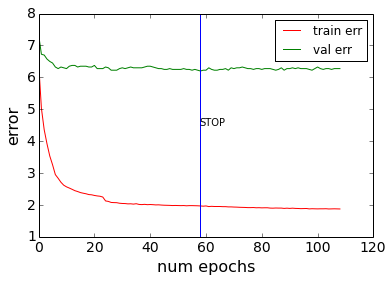

In [260]:
with np.load('results_0.npz') as f:
    arr_0 = f['arr_0'].tolist()
    train_errs_0 = np.asarray(arr_0['train_errs'])
    val_errs_0 = np.asarray(arr_0['val_errs'])
visualize_train_val_errs(train_errs_0, val_errs_0, save_name = 'nn_0')
# visualize_train_val_errs(train_errs_0, val_errs_0)

In [60]:
Ws_1, train_errs_1, val_errs_1, network_1 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[500, 200], 
                                            wd_level=0.003, mb_size=32, learning_rate=0.01, 
                                            max_patience=50, max_epoch=500, momentum_param=0.0)

np.savez_compressed('results_1.npz', {'W' : Ws_1, 'train_errs' : train_errs_1, 'val_errs' : val_errs_1})

Epoch 0, training err 6.607, val err 7.400, patience 50 *
Epoch 1, training err 5.245, val err 6.775, patience 50 *
Epoch 2, training err 4.524, val err 6.575, patience 50 *
Epoch 3, training err 4.165, val err 6.500, patience 50 *
Epoch 4, training err 3.938, val err 6.400, patience 50 *
Epoch 5, training err 3.744, val err 6.300, patience 50 *
Epoch 6, training err 3.649, val err 6.500, patience 49 
Epoch 7, training err 3.569, val err 6.525, patience 48 
Epoch 8, training err 3.507, val err 6.625, patience 47 
Epoch 9, training err 3.442, val err 6.650, patience 46 
Epoch 10, training err 3.384, val err 6.600, patience 45 
Epoch 11, training err 3.359, val err 6.600, patience 44 
Epoch 12, training err 3.334, val err 6.725, patience 43 
Epoch 13, training err 3.317, val err 6.600, patience 42 
Epoch 14, training err 3.175, val err 6.550, patience 41 
Epoch 15, training err 3.162, val err 6.475, patience 40 
Epoch 16, training err 3.137, val err 6.525, patience 39 
Epoch 17, training

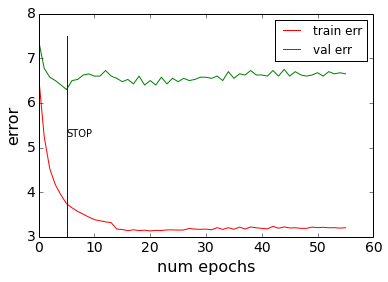

In [261]:
with np.load('results_1.npz') as f:
    arr_0 = f['arr_0'].tolist()
    train_errs_1 = np.asarray(arr_0['train_errs'])
    val_errs_1 = np.asarray(arr_0['val_errs'])
visualize_train_val_errs(train_errs_1, val_errs_1, save_name = 'nn_1')
# visualize_train_val_errs(train_errs_0, val_errs_0)

In [61]:
Ws_2, train_errs_2, val_errs_2, network_2 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[1000, 400], 
                                            wd_level=0.003, mb_size=32, learning_rate=0.01, 
                                            max_patience=50, max_epoch=500, momentum_param=0.0, dropout_prob=[0.2, 0.5, 0.5])

np.savez_compressed('results_2.npz', {'W' : Ws_2, 'train_errs' : train_errs_2, 'val_errs' : val_errs_2})

Epoch 0, training err 9.108, val err 9.375, patience 50 *
Epoch 1, training err 6.696, val err 7.150, patience 50 *
Epoch 2, training err 5.976, val err 6.625, patience 50 *
Epoch 3, training err 5.656, val err 6.550, patience 50 *
Epoch 4, training err 5.282, val err 6.300, patience 50 *
Epoch 5, training err 5.035, val err 6.500, patience 49 
Epoch 6, training err 4.831, val err 6.275, patience 50 *
Epoch 7, training err 4.654, val err 6.425, patience 49 
Epoch 8, training err 4.365, val err 6.150, patience 50 *
Epoch 9, training err 4.232, val err 6.175, patience 49 
Epoch 10, training err 4.167, val err 5.950, patience 50 *
Epoch 11, training err 4.005, val err 5.900, patience 50 *
Epoch 12, training err 3.921, val err 5.850, patience 50 *
Epoch 13, training err 3.938, val err 6.100, patience 49 
Epoch 14, training err 3.913, val err 6.325, patience 48 
Epoch 15, training err 3.921, val err 6.275, patience 47 
Epoch 16, training err 3.808, val err 6.150, patience 46 
Epoch 17, trai

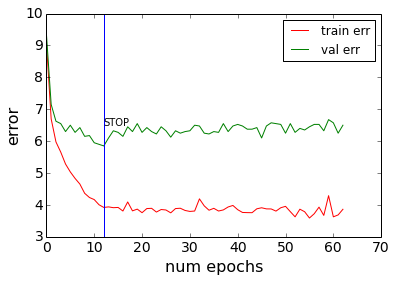

In [262]:
with np.load('results_2.npz') as f:
    arr_0 = f['arr_0'].tolist()
    train_errs_2 = np.asarray(arr_0['train_errs'])
    val_errs_2 = np.asarray(arr_0['val_errs'])
visualize_train_val_errs(train_errs_2, val_errs_2, save_name = 'nn_2')
# visualize_train_val_errs(train_errs_0, val_errs_0)

In [72]:
Ws_3, train_errs_3, val_errs_3, network_3 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[200, 100], 
                                            wd_level=0.003, mb_size=32, learning_rate=0.03, 
                                            max_patience=50, max_epoch=500, momentum_param=0.0, dropout_prob=[0.2, 0.5, 0.5])

np.savez_compressed('results_3.npz', {'W' : Ws_3, 'train_errs' : train_errs_3, 'val_errs' : val_errs_3})

Epoch 0, training err 7.507, val err 8.100, patience 50 *
Epoch 1, training err 5.908, val err 7.000, patience 50 *
Epoch 2, training err 5.245, val err 6.725, patience 50 *
Epoch 3, training err 5.626, val err 6.900, patience 49 
Epoch 4, training err 5.257, val err 6.700, patience 50 *
Epoch 5, training err 5.070, val err 6.625, patience 50 *
Epoch 6, training err 5.033, val err 6.725, patience 49 
Epoch 7, training err 5.053, val err 6.675, patience 48 
Epoch 8, training err 5.267, val err 6.825, patience 47 
Epoch 9, training err 5.287, val err 6.850, patience 46 
Epoch 10, training err 5.340, val err 6.850, patience 45 
Epoch 11, training err 4.948, val err 6.675, patience 44 
Epoch 12, training err 5.237, val err 7.125, patience 43 
Epoch 13, training err 5.005, val err 6.650, patience 42 
Epoch 14, training err 4.833, val err 6.625, patience 41 
Epoch 15, training err 4.901, val err 6.675, patience 40 
Epoch 16, training err 4.953, val err 6.375, patience 50 *
Epoch 17, training

In [88]:
Ws_4, train_errs_4, val_errs_4, network_4 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[200, 100], 
                                            wd_level=0.003, mb_size=32, learning_rate=0.003, 
                                            max_patience=50, max_epoch=500, momentum_param=0.9, dropout_prob=[0.2, 0.5, 0.5])

np.savez_compressed('results_4.npz', {'W' : Ws_4, 'train_errs' : train_errs_4, 'val_errs' : val_errs_4})

Epoch 0, training err 7.335, val err 7.675, patience 50 *
Epoch 1, training err 5.983, val err 6.650, patience 50 *
Epoch 2, training err 5.330, val err 6.525, patience 50 *
Epoch 3, training err 5.080, val err 6.550, patience 49 
Epoch 4, training err 4.868, val err 6.575, patience 48 
Epoch 5, training err 5.168, val err 6.750, patience 47 
Epoch 6, training err 4.744, val err 6.500, patience 50 *
Epoch 7, training err 4.724, val err 6.575, patience 49 
Epoch 8, training err 4.791, val err 6.575, patience 48 
Epoch 9, training err 4.512, val err 6.375, patience 50 *
Epoch 10, training err 4.614, val err 6.375, patience 49 
Epoch 11, training err 4.539, val err 6.325, patience 50 *
Epoch 12, training err 4.666, val err 6.625, patience 49 
Epoch 13, training err 4.779, val err 6.600, patience 48 
Epoch 14, training err 4.355, val err 6.675, patience 47 
Epoch 15, training err 4.599, val err 6.550, patience 46 
Epoch 16, training err 4.487, val err 6.275, patience 50 *
Epoch 17, trainin

In [95]:
Ws_5, train_errs_5, val_errs_5, network_5 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[200, 100]
                                                       , wd_level=0.003, mb_size=32, learning_rate=0.01, max_patience=50
                                                       , max_epoch=500, momentum_param=0.5, dropout_prob=[0.2, 0.5, 0.5]
                                                       , max_norm = 5)

np.savez_compressed('results_5.npz', {'W' : Ws_5, 'train_errs' : train_errs_5, 'val_errs' : val_errs_5})

Epoch 0, training err 7.380, val err 7.850, patience 50 *
Epoch 1, training err 6.115, val err 6.725, patience 50 *
Epoch 2, training err 5.282, val err 6.575, patience 50 *
Epoch 3, training err 5.138, val err 6.475, patience 50 *
Epoch 4, training err 4.883, val err 6.375, patience 50 *
Epoch 5, training err 4.766, val err 6.400, patience 49 
Epoch 6, training err 4.606, val err 6.450, patience 48 
Epoch 7, training err 4.424, val err 6.350, patience 50 *
Epoch 8, training err 4.629, val err 6.325, patience 50 *
Epoch 9, training err 4.798, val err 6.775, patience 49 
Epoch 10, training err 4.360, val err 6.150, patience 50 *
Epoch 11, training err 4.372, val err 6.350, patience 49 
Epoch 12, training err 4.616, val err 6.750, patience 48 
Epoch 13, training err 4.419, val err 6.250, patience 47 
Epoch 14, training err 4.429, val err 6.775, patience 46 
Epoch 15, training err 4.302, val err 6.400, patience 45 
Epoch 16, training err 4.404, val err 6.275, patience 44 
Epoch 17, traini

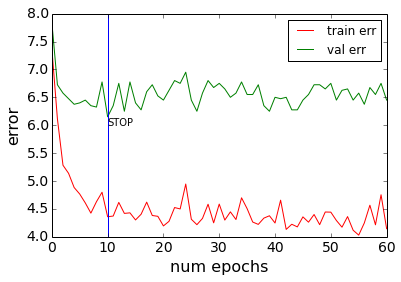

In [263]:
with np.load('results_5.npz') as f:
    arr_0 = f['arr_0'].tolist()
    train_errs_5 = np.asarray(arr_0['train_errs'])
    val_errs_5 = np.asarray(arr_0['val_errs'])
visualize_train_val_errs(train_errs_5, val_errs_5, save_name = 'nn_5')
# visualize_train_val_errs(train_errs_0, val_errs_0)

In [96]:
Ws_6, train_errs_6, val_errs_6, network_6 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[1000, 400]
                                                       , wd_level=0.0, mb_size=32, learning_rate=0.01, max_patience=50
                                                       , max_epoch=500, momentum_param=0.5, dropout_prob=[0.2, 0.5, 0.5]
                                                       , max_norm = 3)

np.savez_compressed('results_6.npz', {'W' : Ws_6, 'train_errs' : train_errs_6, 'val_errs' : val_errs_6})

Epoch 0, training err 7.711, val err 8.350, patience 50 *
Epoch 1, training err 6.048, val err 7.050, patience 50 *
Epoch 2, training err 5.400, val err 6.650, patience 50 *
Epoch 3, training err 5.140, val err 6.550, patience 50 *
Epoch 4, training err 4.893, val err 6.275, patience 50 *
Epoch 5, training err 4.601, val err 6.225, patience 50 *
Epoch 6, training err 4.352, val err 6.225, patience 49 
Epoch 7, training err 4.180, val err 6.275, patience 48 
Epoch 8, training err 4.005, val err 6.075, patience 50 *
Epoch 9, training err 3.741, val err 5.975, patience 50 *
Epoch 10, training err 3.604, val err 5.725, patience 50 *
Epoch 11, training err 3.514, val err 5.850, patience 49 
Epoch 12, training err 3.429, val err 5.650, patience 50 *
Epoch 13, training err 3.349, val err 5.875, patience 49 
Epoch 14, training err 3.409, val err 6.000, patience 48 
Epoch 15, training err 3.165, val err 6.025, patience 47 
Epoch 16, training err 3.085, val err 5.875, patience 46 
Epoch 17, trai

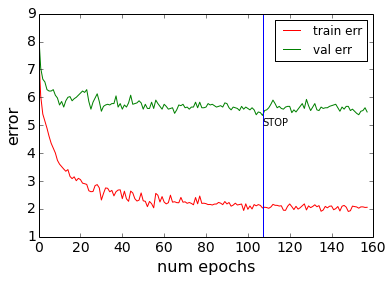

In [264]:
with np.load('results_6.npz') as f:
    arr_0 = f['arr_0'].tolist()
    train_errs_6 = np.asarray(arr_0['train_errs'])
    val_errs_6 = np.asarray(arr_0['val_errs'])
visualize_train_val_errs(train_errs_6, val_errs_6, save_name = 'nn_6')
# visualize_train_val_errs(train_errs_0, val_errs_0)

In [97]:
Ws_7, train_errs_7, val_errs_7, network_7 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[100, 50]
                                                       , wd_level=0.0, mb_size=32, learning_rate=0.01, max_patience=50
                                                       , max_epoch=500, momentum_param=0.5, dropout_prob=[0.2, 0.5, 0.5]
                                                       , max_norm = 3)

np.savez_compressed('results_7.npz', {'W' : Ws_7, 'train_errs' : train_errs_7, 'val_errs' : val_errs_7})

Epoch 0, training err 7.692, val err 8.150, patience 50 *
Epoch 1, training err 6.080, val err 6.925, patience 50 *
Epoch 2, training err 5.484, val err 6.800, patience 50 *
Epoch 3, training err 5.128, val err 6.775, patience 50 *
Epoch 4, training err 4.774, val err 6.575, patience 50 *
Epoch 5, training err 4.631, val err 6.600, patience 49 
Epoch 6, training err 4.242, val err 6.350, patience 50 *
Epoch 7, training err 4.165, val err 6.425, patience 49 
Epoch 8, training err 4.030, val err 6.200, patience 50 *
Epoch 9, training err 4.140, val err 6.250, patience 49 
Epoch 10, training err 3.841, val err 6.175, patience 50 *
Epoch 11, training err 3.711, val err 6.125, patience 50 *
Epoch 12, training err 3.539, val err 6.275, patience 49 
Epoch 13, training err 3.706, val err 6.150, patience 48 
Epoch 14, training err 3.599, val err 5.950, patience 50 *
Epoch 15, training err 3.474, val err 6.075, patience 49 
Epoch 16, training err 3.357, val err 6.050, patience 48 
Epoch 17, trai

In [98]:
Ws_8, train_errs_8, val_errs_8, network_8 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[50]
                                                       , wd_level=0.0, mb_size=32, learning_rate=0.01, max_patience=50
                                                       , max_epoch=500, momentum_param=0.5, dropout_prob=[0.2, 0.5]
                                                       , max_norm = 3)

np.savez_compressed('results_8.npz', {'W' : Ws_8, 'train_errs' : train_errs_8, 'val_errs' : val_errs_8})

Epoch 0, training err 7.297, val err 7.825, patience 50 *
Epoch 1, training err 5.776, val err 6.700, patience 50 *
Epoch 2, training err 5.110, val err 6.425, patience 50 *
Epoch 3, training err 4.926, val err 6.425, patience 49 
Epoch 4, training err 4.586, val err 6.375, patience 50 *
Epoch 5, training err 4.317, val err 6.250, patience 50 *
Epoch 6, training err 4.135, val err 6.150, patience 50 *
Epoch 7, training err 4.010, val err 6.200, patience 49 
Epoch 8, training err 3.978, val err 6.250, patience 48 
Epoch 9, training err 3.933, val err 6.175, patience 47 
Epoch 10, training err 3.843, val err 6.250, patience 46 
Epoch 11, training err 3.773, val err 6.350, patience 45 
Epoch 12, training err 3.861, val err 6.350, patience 44 
Epoch 13, training err 3.674, val err 6.225, patience 43 
Epoch 14, training err 3.616, val err 6.275, patience 42 
Epoch 15, training err 3.561, val err 6.050, patience 50 *
Epoch 16, training err 3.594, val err 5.900, patience 50 *
Epoch 17, traini

In [121]:
Ws_9, train_errs_9, val_errs_9, network_9 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[1000, 400]
                                                       , wd_level=0.00001, mb_size=32, learning_rate=0.01, max_patience=50
                                                       , max_epoch=500, momentum_param=0.5, dropout_prob=[0.2, 0.5, 0.5]
                                                       , max_norm = 3, l1_reg = True)

np.savez_compressed('results_9.npz', {'W' : Ws_9, 'train_errs' : train_errs_9, 'val_errs' : val_errs_9})

Epoch 0, training err 7.677, val err 8.175, patience 50 *
Epoch 1, training err 6.050, val err 7.100, patience 50 *
Epoch 2, training err 5.355, val err 6.650, patience 50 *
Epoch 3, training err 5.050, val err 6.650, patience 49 
Epoch 4, training err 4.853, val err 6.250, patience 50 *
Epoch 5, training err 4.601, val err 6.250, patience 49 
Epoch 6, training err 4.330, val err 6.200, patience 50 *
Epoch 7, training err 4.172, val err 6.125, patience 50 *
Epoch 8, training err 3.975, val err 6.100, patience 50 *
Epoch 9, training err 3.761, val err 6.050, patience 50 *
Epoch 10, training err 3.584, val err 5.875, patience 50 *
Epoch 11, training err 3.469, val err 5.900, patience 49 
Epoch 12, training err 3.429, val err 5.675, patience 50 *
Epoch 13, training err 3.387, val err 6.025, patience 49 
Epoch 14, training err 3.334, val err 5.925, patience 48 
Epoch 15, training err 3.155, val err 6.125, patience 47 
Epoch 16, training err 3.065, val err 5.725, patience 46 
Epoch 17, trai

In [138]:
Ws_10, train_errs_10, val_errs_10, network_10 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[1000, 400]
                                                       , wd_level=0.0, mb_size=32, learning_rate=0.01, max_patience=50
                                                       , max_epoch=500, momentum_param=0.5, dropout_prob=[0.2, 0.5, 0.5]
                                                       , max_norm = 3)

np.savez_compressed('results_10.npz', {'W' : Ws_10, 'train_errs' : train_errs_10, 'val_errs' : val_errs_10})

Epoch 0, training err 6.746, val err 7.550, patience 50 *
Epoch 1, training err 5.260, val err 7.000, patience 50 *
Epoch 2, training err 4.634, val err 6.725, patience 50 *
Epoch 3, training err 4.257, val err 6.450, patience 50 *
Epoch 4, training err 4.038, val err 6.725, patience 49 
Epoch 5, training err 3.781, val err 6.625, patience 48 
Epoch 6, training err 3.551, val err 6.375, patience 50 *
Epoch 7, training err 3.437, val err 6.575, patience 49 
Epoch 8, training err 3.185, val err 6.600, patience 48 
Epoch 9, training err 3.180, val err 6.700, patience 47 
Epoch 10, training err 3.005, val err 6.575, patience 46 
Epoch 11, training err 3.023, val err 6.475, patience 45 
Epoch 12, training err 2.903, val err 6.400, patience 44 
Epoch 13, training err 2.788, val err 6.575, patience 43 
Epoch 14, training err 2.806, val err 6.425, patience 42 
Epoch 15, training err 2.723, val err 6.450, patience 41 
Epoch 16, training err 2.758, val err 6.475, patience 40 
Epoch 17, training 

In [176]:
Ws_11, train_errs_11, val_errs_11, network_11 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[500, 200]
                                                       , wd_level=0.0, mb_size=32, learning_rate=0.01, max_patience=50
                                                       , max_epoch=500, momentum_param=0.5, dropout_prob=[0.2, 0.5, 0.5]
                                                       , max_norm = 3)

np.savez_compressed('results_11.npz', {'W' : Ws_11, 'train_errs' : train_errs_11, 'val_errs' : val_errs_11})

Epoch 0, training err 6.819, val err 7.575, patience 50 *
Epoch 1, training err 5.395, val err 6.675, patience 50 *
Epoch 2, training err 4.661, val err 6.350, patience 50 *
Epoch 3, training err 4.063, val err 6.450, patience 49 
Epoch 4, training err 3.893, val err 6.450, patience 48 
Epoch 5, training err 3.753, val err 6.400, patience 47 
Epoch 6, training err 3.636, val err 6.275, patience 50 *
Epoch 7, training err 3.367, val err 6.400, patience 49 
Epoch 8, training err 3.297, val err 6.150, patience 50 *
Epoch 9, training err 3.182, val err 6.525, patience 49 
Epoch 10, training err 3.083, val err 6.450, patience 48 
Epoch 11, training err 2.985, val err 6.075, patience 50 *
Epoch 12, training err 2.938, val err 6.400, patience 49 
Epoch 13, training err 2.928, val err 6.100, patience 48 
Epoch 14, training err 2.793, val err 6.200, patience 47 
Epoch 15, training err 2.781, val err 6.300, patience 46 
Epoch 16, training err 2.704, val err 6.100, patience 45 
Epoch 17, training

In [179]:
Ws_12, train_errs_12, val_errs_12, network_12 = train_nnet(X_train, Y_train, X_val, Y_val, hid_layer_sizes=[100, 50]
                                                       , wd_level=0.0, mb_size=32, learning_rate=0.01, max_patience=50
                                                       , max_epoch=500, momentum_param=0.5, dropout_prob=[0.2, 0.8, 0.8]
                                                       , max_norm = 3)

np.savez_compressed('results_12.npz', {'W' : Ws_12, 'train_errs' : train_errs_12, 'val_errs' : val_errs_12})

Epoch 0, training err 35.991, val err 34.850, patience 50 *
Epoch 1, training err 33.921, val err 32.575, patience 50 *
Epoch 2, training err 26.309, val err 25.550, patience 50 *
Epoch 3, training err 17.189, val err 16.600, patience 50 *
Epoch 4, training err 13.288, val err 13.525, patience 50 *
Epoch 5, training err 12.545, val err 12.825, patience 50 *
Epoch 6, training err 10.028, val err 10.350, patience 50 *
Epoch 7, training err 8.360, val err 9.100, patience 50 *
Epoch 8, training err 7.507, val err 8.250, patience 50 *
Epoch 9, training err 6.948, val err 7.975, patience 50 *
Epoch 10, training err 6.547, val err 7.700, patience 50 *
Epoch 11, training err 6.512, val err 7.800, patience 49 
Epoch 12, training err 6.307, val err 7.575, patience 50 *
Epoch 13, training err 5.976, val err 7.375, patience 50 *
Epoch 14, training err 6.021, val err 7.425, patience 49 
Epoch 15, training err 5.946, val err 7.350, patience 50 *
Epoch 16, training err 5.766, val err 7.150, patience 

## Analyze best results

In [256]:
def visualize_train_val_errs(train_errs, val_errs, save_name = None):
    # Visualize results
    num_epochs = len(train_errs)
    stop_epoch = np.argmin(val_errs)
    plt.plot(range(num_epochs), train_errs, 'r', label='train err')
    plt.plot(range(num_epochs), val_errs, 'g', label='val err')
    min_y, max_y = plt.ylim()
    plt.plot([stop_epoch, stop_epoch], [min_y, max_y])
    plt.xlabel('num epochs', fontsize = 16)
    plt.ylabel('error', fontsize = 16)
    
    for tick in plt.gca().xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in plt.gca().yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
        
    plt.legend(loc='best')
    plt.text(stop_epoch, (min_y + max_y) / 2, 'STOP')
    plt.locator_params(axis = 'y', nbins = 8)
    if save_name is not None:
        plt.savefig(save_name, dpi = 160)
    plt.show()

In [283]:
def choose_most_confident_predict(network, num_reviews, positive = True):
    predict_fn = compile_predict_fn(network)
    predict_val = predict_fn(X_val.astype(np.float32))
    ids = predict_val[:, int(positive)].argsort()[::-1][:num_reviews]
    return ids, predict_val[ids, :].argmax(axis = 1)


In [284]:
num_reviews = 15
val_id, val_predict = choose_most_confident_predict(network_6, num_reviews, positive = True)

for i in xrange(num_reviews):
    print "Preview #%d" % i
    print "Predict %d, Truth %d" % (val_predict[i], val_df.iloc[val_id[i], -1])
    print val_df.iloc[val_id[i], 1]
    print

Preview #0
Predict 1, Truth 1
Parachutes do not work on the moon. Many Kerbals died to bring us this information.11/10

Preview #1
Predict 1, Truth 1
10/10 community consists of people screaming the n word (thats not a bad thing) don't listen to the negitive nancys out there this is the best game to play with friends and worth how much a spent(idk how much it is)

Preview #2
Predict 1, Truth 1
Bought the game.Started the game for the first time.Began to play. Nearly died from starvation about 6 hours later. Closed the game and got myself some food.Started the game for the second time.Began to play. Forgot about everything around me. Mentioned it was 11pm on sunday evening 7 hours later.Now I'm afraid to start the game again.Edit: 50+ hours and still great, even without mods. I don't want to imagine how much time you are able to "waste" with a variation of mods integrated. Worth every penny.

Preview #3
Predict 1, Truth 1
Bought the game.Started the game for the first time.Began to play

In [285]:
num_reviews = 15
val_id, val_predict = choose_most_confident_predict(network_6, num_reviews, positive = False)

for i in xrange(num_reviews):
    print "Preview #%d" % i
    print "Predict %d, Truth %d" % (val_predict[i], val_df.iloc[val_id[i], -1])
    print val_df.iloc[val_id[i], 1]
    print

Preview #0
Predict 0, Truth 0
Apparently having shadowplay and using a ps4 controller can get you softbanned, so if you aren't using those you're golden.

Preview #1
Predict 0, Truth 0
This game cost me my job, my girlfriend and brung out a horrible side of me I never knew existed.Good job Valve :D

Preview #2
Predict 0, Truth 0
Cancer can be cured,Dota players&community cannot.

Preview #3
Predict 0, Truth 0
Single Player is great, Online not so much as it uses Peer To Peer and hackers are rampant so you have to play in closed friend sessionsNot Recommending because the Online is a broken piece of ****Will update if the issues are ever fixed

Preview #4
Predict 0, Truth 0
Don't get the game for Online, Until Rockstar adds some sort of SERIOUS Anti-Cheat, The Online Portion is absolutely ruined.If your looking for a open world game with an interesting SINGLE Player Story, Or Private Multiplayer with friends, Then this is for you, But if your looking for some drop in and have some open 

In [286]:
def get_most_important_words(network, num_words):
    g = get_gradient_wrt_input(network_6, X_val.astype(np.float32))[:, :5000]
    g_scaled = np.sum(np.abs(g), axis = 0)# / np.sum(X_val[:, :5000], axis = 0)
    feature_names = vectorizer.get_feature_names()
    id_g = g_scaled.argsort()[::-1][:num_words] 
    result = []
    for i in id_g:
        result.append(feature_names[i])
    return result

In [287]:
get_most_important_words(network_6, 20)


[u'fun',
 u'just',
 u'ing',
 u'update',
 u'good',
 u'bad',
 u'community',
 u'valve',
 u'10 10',
 u'rng',
 u'best',
 u'hackers',
 u'banned',
 u'worst',
 u'10',
 u'rocket',
 u'amazing',
 u'updates',
 u'fantastic',
 u'patch']

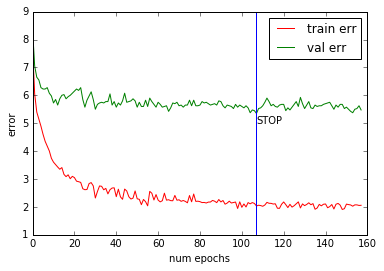

In [288]:
visualize_train_val_errs(train_errs_6, val_errs_6)

## Logistic regression

In [64]:
def sigmoid(S):
    return 1 / (1 + np.exp(-S))

In [65]:
def compute_h(w, X):
    return sigmoid(X.dot(w))

In [66]:
def get_prediction(w, X):
    return compute_h(w, X) > 0.5

In [67]:
def train_lr(train_X, train_Y, val_X, val_Y, learning_rate, max_epoch, max_patience, wd_level = 0.
             , lr_decay = 1., lr_schedule = 10):
    w = np.zeros((train_X.shape[1], 1))
    best_err = 1000
    best_epoch = 0

    patience = max_patience
    train_errs = []
    val_errs = []
    for epoch in range(max_epoch):
        grad = 1. / len(train_X) * train_X.T.dot(compute_h(w, train_X) - train_Y)
        grad += wd_level * 2 * w
        w -= learning_rate * grad

        train_err = np.mean(get_prediction(w, train_X) != train_Y)
        val_err = np.mean(get_prediction(w, val_X) != val_Y)
        train_errs.append(train_err)
        val_errs.append(val_err)
        
        if val_err < best_err:
            best_err = val_err
            patience = max_patience
            best_epoch = epoch
            w_best = w.copy()
        else:
            patience -= 1
            
        best_str = "" if patience < max_patience else " *"
        print 'Epoch %d, training err %.4f, val err %.4f, patience %d%s' % (epoch, train_err, val_err, patience, best_str)
        
        if (epoch + 1) % lr_schedule == 0:
            learning_rate *= lr_decay
            print "New learning rate %.4f" % (learning_rate)
        
        if patience <= 0:
            break
            
    print "Info of returned Ws: epoch %d, train err %.4f, val err %.4f" % \
                (best_epoch, train_errs[best_epoch], val_errs[best_epoch])
        
    return (w_best, train_errs, val_errs)

In [70]:
Ws_lr_0, train_errs_lr_0, val_errs_lr_0 = train_lr(X_train, Y_train, X_val, Y_val
                                                   , learning_rate = 0.1, max_epoch = 500, max_patience = 50
                                                   , wd_level = 0.0)
np.savez_compressed('results_lr_0.npz', {'W' : Ws_lr_0, 'train_errs' : train_errs_lr_0, 'val_errs' : val_errs_lr_0})

Epoch 0, training err 0.2344, val err 0.2301, patience 50 *
Epoch 1, training err 0.1761, val err 0.1760, patience 50 *
Epoch 2, training err 0.1744, val err 0.1742, patience 50 *
Epoch 3, training err 0.1658, val err 0.1667, patience 50 *
Epoch 4, training err 0.1583, val err 0.1588, patience 50 *
Epoch 5, training err 0.1524, val err 0.1545, patience 50 *
Epoch 6, training err 0.1487, val err 0.1488, patience 50 *
Epoch 7, training err 0.1451, val err 0.1448, patience 50 *
Epoch 8, training err 0.1415, val err 0.1403, patience 50 *
Epoch 9, training err 0.1392, val err 0.1386, patience 50 *
New learning rate 0.1000
Epoch 10, training err 0.1331, val err 0.1333, patience 50 *
Epoch 11, training err 0.1317, val err 0.1324, patience 50 *
Epoch 12, training err 0.1303, val err 0.1319, patience 50 *
Epoch 13, training err 0.1295, val err 0.1311, patience 50 *
Epoch 14, training err 0.1260, val err 0.1266, patience 50 *
Epoch 15, training err 0.1217, val err 0.1224, patience 50 *
Epoch 16,

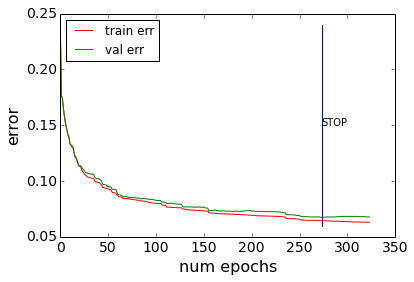

In [258]:
with np.load('results_lr_0.npz') as f:
    arr_0 = f['arr_0'].tolist()
    train_errs_lr_0 = np.asarray(arr_0['train_errs'])
    val_errs_lr_0 = np.asarray(arr_0['val_errs'])
visualize_train_val_errs(train_errs_lr_0, val_errs_lr_0, save_name = 'lr_0')
# visualize_train_val_errs(train_errs_lr_0, val_errs_lr_0)

In [71]:
Ws_lr_1, train_errs_lr_1, val_errs_lr_1 = train_lr(X_train, Y_train, X_val, Y_val
                                                   , learning_rate = 0.1, max_epoch = 500, max_patience = 50
                                                   , wd_level = 0.001)
np.savez_compressed('results_lr_1.npz', {'W' : Ws_lr_1, 'train_errs' : train_errs_lr_1, 'val_errs' : val_errs_lr_1})

Epoch 0, training err 0.2344, val err 0.2301, patience 50 *
Epoch 1, training err 0.1761, val err 0.1760, patience 50 *
Epoch 2, training err 0.1744, val err 0.1742, patience 50 *
Epoch 3, training err 0.1658, val err 0.1667, patience 50 *
Epoch 4, training err 0.1583, val err 0.1588, patience 50 *
Epoch 5, training err 0.1524, val err 0.1545, patience 50 *
Epoch 6, training err 0.1487, val err 0.1488, patience 50 *
Epoch 7, training err 0.1451, val err 0.1448, patience 50 *
Epoch 8, training err 0.1415, val err 0.1403, patience 50 *
Epoch 9, training err 0.1392, val err 0.1386, patience 50 *
New learning rate 0.1000
Epoch 10, training err 0.1331, val err 0.1333, patience 50 *
Epoch 11, training err 0.1317, val err 0.1324, patience 50 *
Epoch 12, training err 0.1303, val err 0.1319, patience 50 *
Epoch 13, training err 0.1295, val err 0.1311, patience 50 *
Epoch 14, training err 0.1260, val err 0.1266, patience 50 *
Epoch 15, training err 0.1218, val err 0.1224, patience 50 *
Epoch 16,

# Final result on test set

In [289]:
test_df = pd.DataFrame.from_csv('../data/clean/test_reviews.csv')
test_df.dropna(inplace = True)
print test_df.polarity.describe()
test_df.head()

count    6689.000000
mean        0.652414
std         0.476239
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: polarity, dtype: float64


,hour_of_gameplay,content_review,helpful_vote,total_vote,funny_vote,number_comment,polarity
ID,,,,,,,
730,99.0,"It's community is 99% Salty and Toxic. ""Team-B...",1,1,0,0,0
730,946.5,HU3HU3HU3 SERVERS IN BRASIL LATINO AMERICA INF...,1,1,0,0,0
730,815.1,800 HOURS OF LOST OPPORTUNITIES,2,2,2,1,1
730,794.1,♥♥♥♥ blyat..,3,3,0,0,1
730,524.8,REVOLVER,2,2,1,1,0


In [290]:
_, X_test, Y_test = vectorize_data(test_df, vectorizer)
print X_test.shape, Y_test.shape

(6689, 5004) (6689, 1)


In [291]:
X_test, _, _ = preprocess_data(X_test, X_mean, X_std)

print "Mean and standard deviation on test set:"
print X_test.mean(axis = 0)
print X_test.std(axis = 0)

Mean and standard deviation on test set:
[-0.00575411 -0.01440052  0.01294247 ...,  0.008861    0.00986557
  0.00244711]
[ 1.00239535  0.80816538  1.03358168 ...,  1.05554496  1.01949102
  1.02652616]


In [300]:
acc_fn = compile_acc_fn(network_6)
acc_test = acc_fn(X_test.astype(np.float32), Y_test.reshape(-1,).astype(np.int32))
print "Error on test set = %.4f%%" % ((1 - acc_test) * 100)

Error on test set = 5.7557%
